In [2]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 349 kB/s 


In [3]:
!pip install rectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 13.5 MB 38.4 MB/s 
     |████████████████████████████████| 310 kB 53.9 MB/s 
     |████████████████████████████████| 60 kB 7.3 MB/s 
     |████████████████████████████████| 88 kB 8.5 MB/s 
     |████████████████████████████████| 1.1 MB 63.7 MB/s 
     |████████████████████████████████| 188 kB 64.3 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3421672 sha256=4b0eb961ef34c0b5fa88930f3d024ed79b1631106672fd2d0535fbd9cd246d00
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705385 sha256=a6ec74367e097885a10d79d0c69f390aa589fe817e431aea25ecc186f3d9598d
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3b

In [4]:
import numpy as np
import pandas as pd

from implicit.nearest_neighbours import TFIDFRecommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Dataset, SparseFeatures, DenseFeatures, IdMap, Interactions
from rectools.metrics import (
    Precision,
    Recall,
    calc_metrics,
)
from rectools.models import ImplicitALSWrapperModel
from rectools.models import ImplicitItemKNNWrapperModel

**Подготовка данных** 
В данной работе я буду пользоваться учебным набором данных, содержащим информацию о пользователе, песне и рейтенге, который пользователь поставил песне.

Подробную информацию о датасете можно прочитать по ссылке: https://www.kaggle.com/datasets/rymnikski/dataset-for-collaborative-filters (2млн записей)


1) Датасет с информацией об оценке песен

In [6]:
ratings = pd.read_csv(
    "user_song_rating.csv",
    sep=",",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime]
)
ratings = ratings.drop([0])
ratings = ratings.iloc[0:1000000, 0:4]
print(ratings.shape)
ratings.head()

(1000000, 4)


,user_id,item_id,weight,datetime
1,0,7171,5,NaN
2,0,8637,4,NaN
3,0,21966,4,NaN
4,0,35821,5,NaN
5,0,82446,5,NaN


2) Разделение датасета на test и train

In [7]:
df_train = ratings.sample(frac=0.8)
df_test = ratings.drop(df_train.index)

In [8]:
dataset = Dataset.construct(df_train)

Будем предлагать пользователю по 10 рекомендаций.

Было интересно попробовать что-то новое и поработать с библиотекой Rectools (подробное описание https://rectools.readthedocs.io/en/latest/index.html ).

Функция ImplicitALSWrapperModel берет за основу функцию AlternatingLeastSquares из библиотеки implicit. Одними из главных гиперпарметров для ALS служат 

**iterations** - количество итераций ALS, которое необходимо использовать при обучении модели

**factors** - по сути, это количество абстрактной информации, которую мы хотим хранить в пространстве меньшей размерности. Latent factors образуют векторное пространство из users и items для удобства их сравнивания.

**regularization** - это коэффициент регуляризации. По сути является ограничителем для того, чтобы не произошло переобучение модели.

Поискав информацию на подобные темы были подобраны параметры для AlternatingLeastSquares.
Одними из главных гипе

Тк в задаче нам требовалось построить метрики, зависящие от числа рекоммендованных песен, то я сделал цикл для сбора значений precision и recall для соответсвующих k

In [9]:
def make_base_model():
    # Need to create new base model every time to use same random initializations
    return AlternatingLeastSquares(factors = 20, regularization=0.05, iterations=10)

In [10]:
als_precision = []
als_recall = []
for p in range(1,11):
  metrics = {"precision@k": Precision(p), "recall@k": Recall(p)}

  model = ImplicitALSWrapperModel(make_base_model())
  model.fit(dataset)
  recos = model.recommend(
      users=df_test[Columns.User].unique(),
      dataset=dataset,
      k = 10,
      filter_viewed=True
  )
  als_precision.append(calc_metrics(metrics, recos, df_test, df_train)['precision@k'])
  als_recall.append(calc_metrics(metrics, recos, df_test, df_train)['recall@k'])

Выше была реализована система рекомендаций на основании ALS

Теперь перейдем к KNN. Опять же, в библиотеке rectools есть обертка для функции TFIDFRecommender из implicit.

Также была собрана информация по метрикам precision и recall для соответсвующего k. В библиотеке есть методы, которые позволяют посчитать данные метрики.

In [11]:
knn_precision = []
knn_recall = []
for l in range(1,11):
  metrics = {"precision@k": Precision(l), "recall@k": Recall(l)}

  model2 = ImplicitItemKNNWrapperModel(TFIDFRecommender(K=10))
  model2.fit(dataset)

  # Make recommendations
  recos2 = model2.recommend(
      users=ratings[Columns.User].unique(),
      dataset=dataset,
      k = 10,
      filter_viewed=True,
  )
  knn_precision.append(calc_metrics(metrics, recos2, df_test, df_train)['precision@k'])
  knn_recall.append(calc_metrics(metrics, recos2, df_test, df_train)['recall@k'])

In [33]:
print(als_recall)

[0.016638636304178014]


In [39]:
print(als_recall)

[]


**Визуализация метрик**

В контексте рекомендательных систем мы заинтересованы в том, чтобы рекомендовать пользователю N лучших элементов. Поэтому логичнее вычислять метрики precision и recall для первых N элементов, а не для всех элементов. Таким образом, понятия precision@k и recall@k, где k - определяемое пользователем целое число, которое задается пользователем для соответствия цели рекомендаций топ-N.

Метрика **precision@k** это количество релевантных рекомендаций среди первых k элементов в списке из n рекомендованных деленное на k.

А **recall@k** это это количество релевантных рекомендаций среди первых k элементов в списке из n рекомендованных деленное на количество элементов, которое человек оценил в конкретную сессию

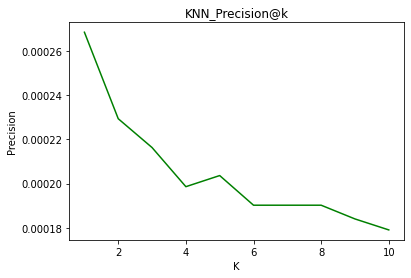

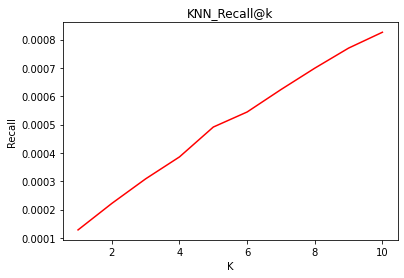

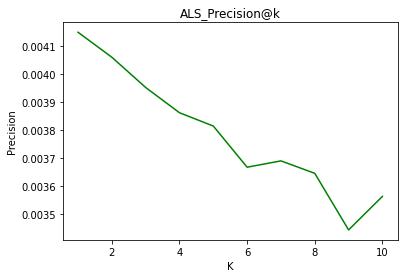

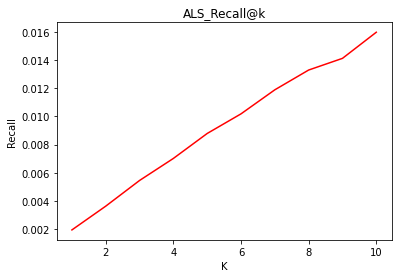

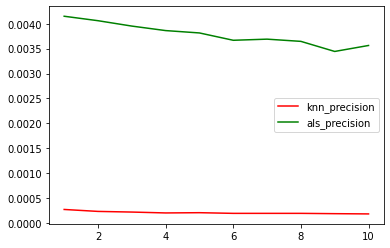

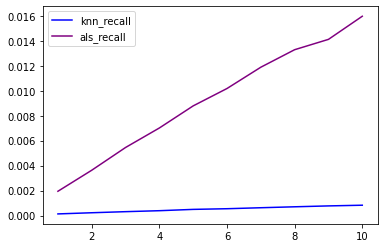

In [15]:
import matplotlib.pyplot as plt


list_k = (1,2,3,4,5,6,7,8,9,10)

fig, ax = plt.subplots()
ax.plot(list_k, knn_precision, color='green')
ax.set_title('KNN_Precision@k')
ax.set_ylabel('Precision')
ax.set_xlabel('K')
plt.show() 

fig, ay = plt.subplots()
ay.plot(list_k, knn_recall, color='red')
ay.set_title('KNN_Recall@k')
ay.set_ylabel('Recall')
ay.set_xlabel('K')
plt.show() 

fig, aw = plt.subplots()
aw.plot(list_k, als_precision, color='green')
aw.set_title('ALS_Precision@k')
aw.set_ylabel('Precision')
aw.set_xlabel('K')
plt.show() 

fig, az = plt.subplots()
az.plot(list_k, als_recall, color='red')
az.set_title('ALS_Recall@k')
az.set_ylabel('Recall')
az.set_xlabel('K')
plt.show() 

plt.plot(list_k, knn_precision, color='red', label='knn_precision')
plt.plot(list_k, als_precision, color='green', label='als_precision')
plt.legend(loc='best')
plt.show()

plt.plot(list_k, knn_recall, color='blue', label='knn_recall')
plt.plot(list_k, als_recall, color='purple', label='als_recall')
plt.legend(loc='best')
plt.show()

**Вывод**

Мы знаем, что Recall измеряет способность модели обнаруживать выборки, которые конкретный юзер оценил. Чем выше recall, тем больше оцененных семплов конкретным пользователем было найдено. А precision помогает узнать, насколько точна модель, когда она говорит, что конкретному пользователю стоит рекомендовать именно это трек. Если она высока, вы можете доверять решению модели. 

Из графиков видно, что ALS работает лучше.